In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import cmath


from finite_groups import *

from activation_funcs import *

In [ ]:
# ==============================================================================
# HELPER: A5 DATA GENERATION
# ==============================================================================
def get_a5_data():
    """Generates A5 elements, classes, and characters for use in the main logic."""
    # 1. Elements (Even permutations of S5)
    all_perms = list(it.permutations(range(5)))
    a5_perms = []
    
    for p in all_perms:
        # Calculate sign
        invs = 0
        for i in range(len(p)):
            for j in range(i+1, len(p)):
                if p[i] > p[j]:
                    invs += 1
        if invs % 2 == 0:
            a5_perms.append(p)

    # 2. Representatives & Classes (Standard A5)
    # 1A: Identity
    rep_1a = (0, 1, 2, 3, 4)
    # 2A: (0 1)(2 3) -> (1, 0, 3, 2, 4)
    rep_2a = (1, 0, 3, 2, 4)
    # 3A: (0 1 2) -> (1, 2, 0, 3, 4)
    rep_3a = (1, 2, 0, 3, 4)
    # 5A: (0 1 2 3 4) -> (1, 2, 3, 4, 0)
    rep_5a = (1, 2, 3, 4, 0)
    # 5B: (0 1 3 2 4) -> (1, 3, 4, 2, 0) (This is (0 1 2 3 4)^2)
    # Note: In A5, (12345) and (13524) are not conjugate.
    rep_5b = (1, 3, 4, 2, 0)

    reps = [rep_1a, rep_2a, rep_3a, rep_5a, rep_5b]
    
    # 3. Character Table Rows
    # Cols: 1A, 2A, 3A, 5A, 5B
    # Constants
    sqrt5 = sp.sqrt(5)
    phi = (1 + sqrt5) / 2
    phi_conj = (1 - sqrt5) / 2 # 1 - phi

    chars = [
        [1,  1,  1,       1,        1], # Chi1 (Triv)
        [3, -1,  0,     phi, phi_conj], # Chi3 (Standard)
        [3, -1,  0, phi_conj,     phi], # Chi3' (Conjugate)
        [4,  0,  1,      -1,       -1], # Chi4
        [5,  1, -1,       0,        0]  # Chi5
    ]
    
    return a5_perms, reps, chars

# ==============================================================================
# SECTION 1: DEFINE GROUP (G = C2 x A5)
# ==============================================================================
def define_group():
    """
    Define G = C2 x A5.
    Elements are tuples (c, p) where c is int, p is tuple.
    """
    a5_perms, _, _ = get_a5_data()
    c2_elems = [1, -1]
    
    # Cross product
    elements = []
    for c in c2_elems:
        for p in a5_perms:
            elements.append((c, p))
            
    def mult_func(e1, e2):
        # e1 = (c1, p1), e2 = (c2, p2)
        c1, p1 = e1
        c2, p2 = e2
        
        # Multiply C2 part
        c_new = c1 * c2
        
        # Multiply A5 part: p_new[i] = p1[p2[i]]
        p_new = tuple(p1[x] for x in p2)
        
        return (c_new, p_new)

    return elements, mult_func

# ==============================================================================
# SECTION 2: DEFINE SUBGROUP (H)
# ==============================================================================
def define_subgroup(G: FiniteGroup):
    """
    Define H. We choose H isomorphic to A4 inside the A5 component, 
    and trivial inside C2.
    H = { (1, p) | p in A5, p(4) = 4 }
    Order of G = 2 * 60 = 120.
    Order of H = 1 * 12 = 12.
    Index = 10.
    """
    H = []
    
    # We can iterate G elements and check the condition
    for g in G.elements:
        c, p = g
        # Condition: C2 part is identity (1) AND A5 part fixes element 4
        if c == 1 and p[4] == 4:
            H.append(g)
            
    return H

# ==============================================================================
# SECTION 3: DEFINE CONJUGACY CLASSES (MANUAL)
# ==============================================================================
def define_conjugacy_classes():
    """
    Generate 10 classes for C2 x A5.
    Classes are (c_class) x (a5_class).
    """
    a5_perms, a5_reps, _ = get_a5_data()
    
    # Helper to find full class members in A5 for a rep
    def get_class_members(rep):
        members = set()
        rep_inv = [0]*5
        for i, val in enumerate(rep): rep_inv[val] = i
        rep_inv = tuple(rep_inv)
        
        # Conjugate by all a5 perms
        for p in a5_perms:
            # p * rep * p^-1
            # calc p_inv
            p_inv = [0]*5
            for i, val in enumerate(p): p_inv[val] = i
            
            # rep * p_inv
            step1 = tuple(rep[x] for x in p_inv)
            # p * step1
            conj = tuple(p[x] for x in step1)
            members.add(conj)
        return list(members)

    classes = []
    
    # Iterate C2 components
    for c in [1, -1]:
        # Iterate A5 components
        for rep in a5_reps:
            full_rep = (c, rep)
            
            # Build members list
            a5_members = get_class_members(rep)
            full_members = [(c, m) for m in a5_members]
            
            classes.append( (full_rep, full_members) )
            
    return classes

# ==============================================================================
# SECTION 4: CHARACTER TABLE (C2 x A5)
# ==============================================================================
def define_character_table():
    """
    Generate 10x10 table via tensor product.
    Rows: (C2_char) x (A5_char)
    Cols: Classes generated in Section 3
    """
    _, a5_reps, a5_chars = get_a5_data()
    
    # C2 Chars: [1, 1] and [1, -1]
    c2_chars = [
        {1: 1, -1: 1},  # Trivial
        {1: 1, -1: -1}  # Sign
    ]
    
    char_map = {}
    labels = []
    
    # Loop over all combinations of characters
    for c2_chi in c2_chars:
        for a5_chi_row in a5_chars:
            
            # This combination forms one row of the new table
            # We need to compute its value for every Representative defined in Sec 3
            
            for c_val in [1, -1]:
                for i, rep in enumerate(a5_reps):
                    full_rep = (c_val, rep)
                    
                    # Value = Chi_C2(c) * Chi_A5(p)
                    val = c2_chi[c_val] * a5_chi_row[i]
                    
                    if full_rep not in char_map:
                        char_map[full_rep] = []
                    
                    char_map[full_rep].append(val)
    
    # Generate labels
    # A5 labels
    a5_labels = ["1", "3", "3'", "4", "5"]
    c2_labels = ["+", "-"]
    
    for l1 in c2_labels:
        for l2 in a5_labels:
            labels.append(f"{l2}^{l1}")

    return char_map, labels

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
def run_analysis():
    print(">>> 1. Loading Group Data (C2 x A5)...")
    elements, mult_func = define_group()
    classes_data = define_conjugacy_classes()
    
    G = FiniteGroup(elements, mult_func, classes=classes_data)
    print(f"    Group Order: {G.n}")
    
    print("\n>>> 2. Loading Subgroup Data...")
    # H = Stabilizer of '4' in A5 component, Trivial in C2 component
    H_elements = define_subgroup(G)
    solver = InducedRepSolver(G)
    solver.set_subgroup(H_elements)
    
    print("\n>>> 3. Loading Character Table...")
    char_map, labels = define_character_table()
    solver.load_character_table(char_map, irrep_labels=labels)
    
    print("\n>>> 4. Computing Exact Projectors (SymPy)...")
    solver.compute_projectors()
    
    print("\n>>> 5. Induced Representation Decomposition:")
    for label, Q in solver.Qblocks.items():
        if Q.shape[1] > 0:
            print(f"    Irrep '{label}' appears with dimension {Q.shape[1]}")
    
    print("\n>>> 6. Building Interaction Graph...")
    def relu_sym(x): return sp.Max(0, x)

    activation_fn = relu_sym
    
    graph = solver.build_interaction_graph(activation_fn=activation_fn, verbose=True)
    print(f"    Edges found: {graph.edges()}")
    
    if len(graph.nodes) > 0:
        plt.figure(figsize=(6, 6))
        pos = nx.spring_layout(graph, seed=42)
        nx.draw_networkx(graph, pos, node_color="#E8F0FF", edgecolors="blue", 
                         node_size=1000, font_weight="bold", with_labels=True)
        plt.title(f"C2xA5 ({activation_fn.__name__})")
        plt.show()

>>> 1. Loading Group Data (C2 x A5)...
Building multiplication table for G (order 120)...
Using user-provided Conjugacy Classes.
    Group Order: 120

>>> 2. Loading Subgroup Data...
Computed 10 cosets for H (order 12) in G (order 120).

>>> 3. Loading Character Table...
Character table loaded (SymPy).

>>> 4. Computing Exact Projectors (SymPy)...

>>> 5. Induced Representation Decomposition:
    Irrep '1^+' appears with dimension 1
    Irrep '4^+' appears with dimension 4
    Irrep '1^-' appears with dimension 1
    Irrep '4^-' appears with dimension 4

>>> 6. Building Interaction Graph...
Irreps present: ['1^+', '4^+', '1^-', '4^-']
    Edges found: [('1^+', '1^+'), ('4^+', '1^+'), ('4^+', '4^+'), ('1^-', '1^+'), ('1^-', '1^-'), ('4^-', '1^+'), ('4^-', '4^+'), ('4^-', '4^-')]


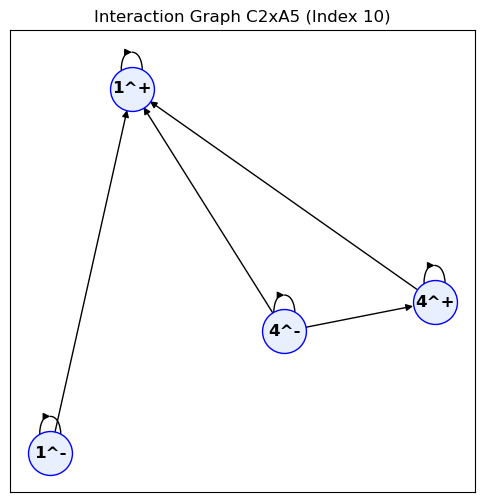

In [6]:
run_analysis()